# 手写FashionMNIST分类

In [1]:
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import autograd
from mxnet import gluon
%matplotlib inline
import matplotlib.pyplot as plt
mx.random.seed(1)

## 设置context

In [19]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

## 加载数据集

In [2]:
# 将图片转换为float，并normalize为[0,1]区间
def transform(data, label):
    return data.astype(np.float32) / 255, label.astype(np.float32)
fashion_mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
fashion_mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [3]:
data, label = fashion_mnist_train[0:9]
print(data.shape)
print(label)
print(len(fashion_mnist_train))
print(len(fashion_mnist_test))

(9, 28, 28, 1)
[ 2.  9.  6.  0.  3.  4.  4.  5.  4.]
60000
10000


In [4]:
batch_size = 256 
train_data = gluon.data.DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

In [5]:
# 画出十张图片
def show_images(images):
    token = images.shape[0] # token张图片
    _, figs = plt.subplots(1, token, figsize=(15, 15))
    for i, img in enumerate(images):
        figs[i].imshow(img.reshape((img.shape[0], img.shape[1])).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()
    
def get_label_text(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

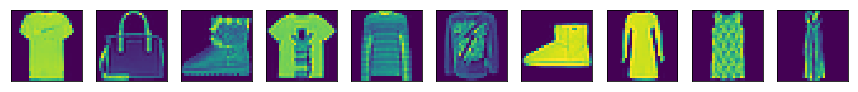

['t-shirt', 'bag', 'ankle boot', 't-shirt', 'pullover', 'pullover', 'ankle boot', 'dress,', 'dress,', 'dress,']


In [6]:
images, label = fashion_mnist_train[10:20]
show_images(images)

print(get_label_text(label))

## 随机初始化参数

In [7]:
num_outputs = 10
num_inputs = 784
num_examples = len(fashion_mnist_train)

W = nd.random.normal(shape=(num_inputs, num_outputs))
b = nd.random.normal(shape=num_outputs)

params = [W, b]

In [8]:
for param in params:
    param.attach_grad()

## 定义模型

$$softmax(z) = \frac{e^z}{\sum^k_{i=1} e^{z_i}}$$

##  定义softmax分类器

In [9]:
# 方法一
def softmax(output):
    yexp = nd.exp(output)
    ysum = yexp.sum(axis=1, keepdims=True)
    return yexp / ysum

# 方法二
def softmax(output):
    y = nd.exp(output - nd.max(output, axis=1).reshape((-1,1)))
    yhat = y / nd.sum(y, axis=1).reshape((-1, 1))
    return yhat

In [10]:
X = nd.random.normal(shape=(2,5))
X_prob = softmax(X)
print(X_prob)
print(X_prob.sum(axis=1, keepdims=True))


[[ 0.02013398  0.74854225  0.08711927  0.12285224  0.02135231]
 [ 0.20664689  0.09196832  0.05960708  0.3803944   0.26138332]]
<NDArray 2x5 @cpu(0)>

[[ 1.]
 [ 1.]]
<NDArray 2x1 @cpu(0)>


##  定义网络

In [11]:
def net(X):
    output = nd.dot(X.reshape((-1,784)), W) + b # (m,k) = (m,d) * (d,k) + (m,k)
    yhat = softmax(output) # (m,k)
    return yhat

In [12]:
# 测试
X = nd.random.normal(shape=(2, 784))
a = net(X)
print(nd.sum(a, axis=1, keepdims=True))
print(a)


[[ 1.]
 [ 1.]]
<NDArray 2x1 @cpu(0)>

[[  2.61078318e-16   1.79572725e-22   2.13455920e-10   3.87708457e-40
    1.50150685e-13   2.64930338e-01   2.80820146e-18   6.35677027e-30
    1.87918721e-22   7.35069633e-01]
 [  1.40898841e-24   4.41780657e-08   9.05528441e-26   4.23220367e-22
    9.86225724e-01   5.74204345e-21   2.47369317e-04   1.35268923e-02
    3.09138538e-17   5.39053463e-27]]
<NDArray 2x10 @cpu(0)>


## 定义交叉熵损失函数

In [13]:
def cross_entropy(yhat, y):
    return -nd.sum(y * nd.log(yhat + 1e-6))

## 定义优化器

In [14]:
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

## 定义评估函数

In [15]:
def evaluate_accuracy(img_iter, net):
    numerator = 0.0
    denominator = 0.0
    for data, label in img_iter:
        data = data.reshape((-1, num_inputs))
        output = net(data)
        prediction = nd.argmax(output, axis=1)
        numerator += nd.sum(prediction == label)
        niter = data.shape[0]
        denominator += niter
    return (numerator / denominator).asscalar()

In [16]:
evaluate_accuracy(test_data, net)

0.119

## 训练

In [17]:
epochs = 100
learning_rate = 0.1

for epoch in range(epochs):
    cumulative_loss = 0.0
    if epoch >= 50:
        learning_rate = 0.1 * learning_rate
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1, num_inputs))
        one_hot_label = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, one_hot_label)
        loss.backward()
        # 将梯度做平均，这样学习率会对batch_size不那么敏感
        SGD(params, learning_rate / batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    
    train_acc = evaluate_accuracy(train_data, net)
    test_acc = evaluate_accuracy(test_data, net)
    print("Epoch %s, Avg loss %s, Train acc %s, Test acc %s." 
          % (epoch, cumulative_loss / num_examples, train_acc, test_acc))

Epoch 0, Avg loss 4.10266917826, Train acc 0.572733, Test acc 0.5687.
Epoch 1, Avg loss 1.86122149963, Train acc 0.660233, Test acc 0.6565.
Epoch 2, Avg loss 1.54041158269, Train acc 0.694233, Test acc 0.6928.
Epoch 3, Avg loss 1.38399034983, Train acc 0.714667, Test acc 0.7168.
Epoch 4, Avg loss 1.28035689875, Train acc 0.728417, Test acc 0.7287.
Epoch 5, Avg loss 1.20663685239, Train acc 0.739467, Test acc 0.7436.
Epoch 6, Avg loss 1.14824641953, Train acc 0.746733, Test acc 0.7481.
Epoch 7, Avg loss 1.10008482564, Train acc 0.753567, Test acc 0.7552.
Epoch 8, Avg loss 1.06064088885, Train acc 0.7616, Test acc 0.7627.
Epoch 9, Avg loss 1.02592703298, Train acc 0.7642, Test acc 0.7643.
Epoch 10, Avg loss 0.994827369563, Train acc 0.769233, Test acc 0.7718.
Epoch 11, Avg loss 0.968028613917, Train acc 0.771717, Test acc 0.7731.
Epoch 12, Avg loss 0.943662668737, Train acc 0.775417, Test acc 0.7762.
Epoch 13, Avg loss 0.921533769989, Train acc 0.776717, Test acc 0.778.
Epoch 14, Avg los

## 预测

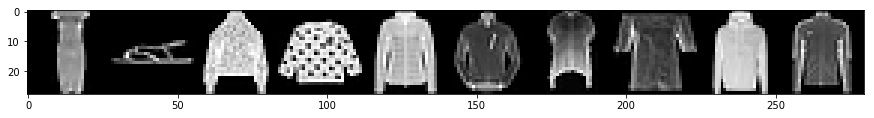

true label:
 ['dress,', 'sandal', 'shirt', 'pullover', 'coat', 'coat', 'shirt', 'shirt', 'pullover', 'coat']
pred label:
 ['trouser', 'sandal', 'coat', 'shirt', 'coat', 'shirt', 'shirt', 'shirt', 'coat', 'pullover']


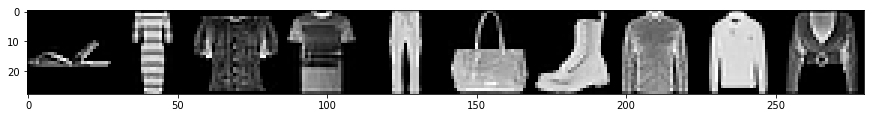

true label:
 ['sandal', 'dress,', 'shirt', 't-shirt', 'trouser', 'bag', 'ankle boot', 'shirt', 'pullover', 'shirt']
pred label:
 ['sandal', 'dress,', 'bag', 't-shirt', 'trouser', 'bag', 'ankle boot', 'coat', 'pullover', 'trouser']


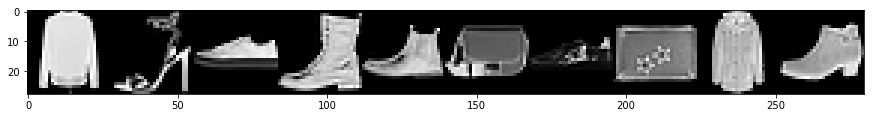

true label:
 ['pullover', 'sandal', 'sneaker', 'ankle boot', 'ankle boot', 'bag', 'sneaker', 'bag', 'coat', 'ankle boot']
pred label:
 ['pullover', 'sandal', 'sneaker', 'ankle boot', 'ankle boot', 'bag', 'sandal', 'bag', 'coat', 'ankle boot']


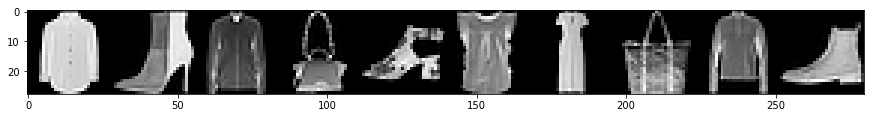

true label:
 ['shirt', 'ankle boot', 'coat', 'bag', 'sandal', 'shirt', 'dress,', 'bag', 'pullover', 'ankle boot']
pred label:
 ['coat', 'ankle boot', 'shirt', 'bag', 'ankle boot', 'shirt', 'dress,', 'bag', 'shirt', 'ankle boot']


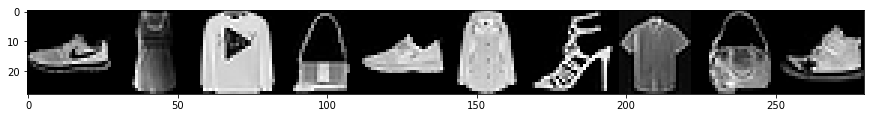

true label:
 ['sneaker', 't-shirt', 'pullover', 'bag', 'sneaker', 'coat', 'sandal', 'shirt', 'bag', 'sneaker']
pred label:
 ['sneaker', 'dress,', 'pullover', 'bag', 'sneaker', 'coat', 'sandal', 'shirt', 'sandal', 'sneaker']


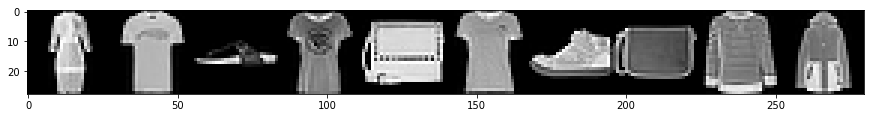

true label:
 ['dress,', 't-shirt', 'sandal', 't-shirt', 'bag', 't-shirt', 'sneaker', 'bag', 'pullover', 'coat']
pred label:
 ['dress,', 't-shirt', 'sandal', 't-shirt', 'bag', 't-shirt', 'sneaker', 'bag', 'pullover', 'coat']


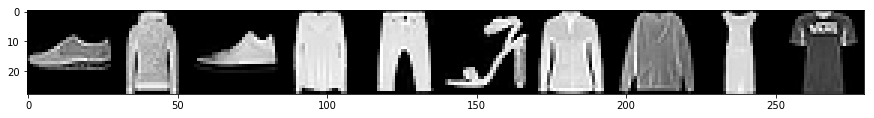

true label:
 ['sneaker', 'pullover', 'sneaker', 'pullover', 'trouser', 'sandal', 'shirt', 'pullover', 'dress,', 't-shirt']
pred label:
 ['sneaker', 'pullover', 'sneaker', 'pullover', 'trouser', 'sandal', 'shirt', 'pullover', 'dress,', 't-shirt']


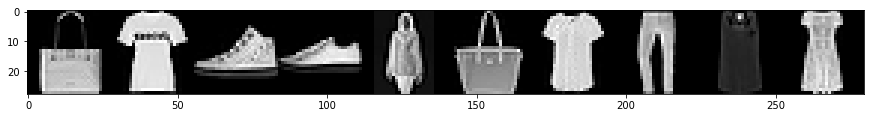

true label:
 ['bag', 't-shirt', 'sneaker', 'sneaker', 'coat', 'bag', 'shirt', 'trouser', 't-shirt', 'dress,']
pred label:
 ['bag', 't-shirt', 'sneaker', 'sneaker', 't-shirt', 'bag', 't-shirt', 'trouser', 'dress,', 'dress,']


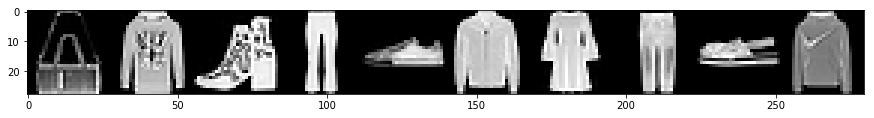

true label:
 ['bag', 'pullover', 'ankle boot', 'trouser', 'sneaker', 'coat', 'dress,', 'trouser', 'sandal', 'pullover']
pred label:
 ['bag', 'pullover', 'ankle boot', 'trouser', 'sneaker', 'coat', 'dress,', 'dress,', 'bag', 'pullover']


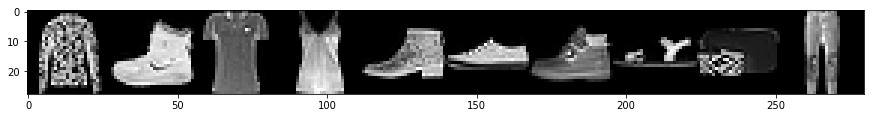

true label:
 ['coat', 'ankle boot', 'shirt', 'shirt', 'ankle boot', 'sneaker', 'ankle boot', 'sandal', 'bag', 'trouser']
pred label:
 ['pullover', 'ankle boot', 't-shirt', 'bag', 'ankle boot', 'sneaker', 'ankle boot', 'sandal', 'bag', 'trouser']


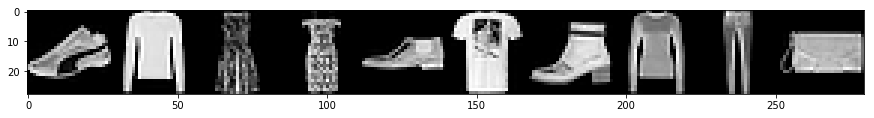

true label:
 ['sneaker', 'pullover', 'dress,', 'dress,', 'ankle boot', 't-shirt', 'ankle boot', 'pullover', 'trouser', 'bag']
pred label:
 ['sandal', 'pullover', 'dress,', 'dress,', 'ankle boot', 't-shirt', 'ankle boot', 'pullover', 'trouser', 'bag']


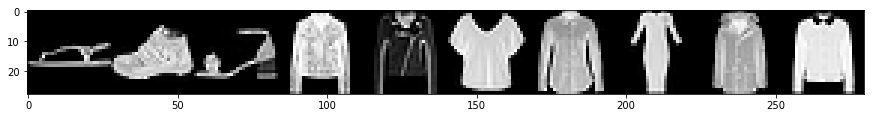

true label:
 ['sandal', 'ankle boot', 'sandal', 'coat', 'coat', 't-shirt', 'shirt', 'dress,', 'coat', 'coat']
pred label:
 ['sandal', 'sneaker', 'sandal', 'coat', 'pullover', 't-shirt', 'shirt', 'dress,', 'coat', 'pullover']


In [18]:
def model_prediction(net, data):
    output = net(data) # (m,k)
    return nd.argmax(output, axis=1)

# 每次拿出10个数据 画出来并比较预测准确率
sample_data = gluon.data.DataLoader(fashion_mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data_trans = nd.transpose(data, (1,0,2,3)) # height * batch * width * channel
    data_concat = nd.reshape(data_trans, (data_trans.shape[0], -1, 1))
    im_tile = nd.tile(data_concat, (1,1,3))
    plt.figure(figsize=(15, 15))
    plt.imshow(im_tile.asnumpy())
    plt.show()
    print("true label:\n", get_label_text(label.asnumpy()))
    prediction = model_prediction(net, data)
    print("pred label:\n", get_label_text(prediction.asnumpy()))
    if i > 10:
        break